## Import

In [20]:
from model_class_model_cnn6 import *
import os
import sys

In [21]:
# 필요한 라이브러리 임포트
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import json

In [22]:
import torch.nn.functional as F
from tqdm import tqdm
from ptflops import get_model_complexity_info
import time
import random
import torchvision.transforms.functional as TF
import lpips

In [23]:
import warnings
import logging

logging.getLogger().setLevel(logging.ERROR)

# 경고 메시지 억제
warnings.filterwarnings("ignore")

## Dataset

In [24]:
class SRDataAugmentation:
    def __init__(self, p=1):
        """
        데이터 증강 클래스
        :param p: 증강 적용 확률
        """
        self.p = p

    def __call__(self, lr_img, hr_img):
        if random.random() < self.p:
            # 랜덤 수평 뒤집기
            if random.random() < 0.5:
                lr_img = TF.hflip(lr_img)
                hr_img = TF.hflip(hr_img)

            # 랜덤 수직 뒤집기
            if random.random() < 0.5:
                lr_img = TF.vflip(lr_img)
                hr_img = TF.vflip(hr_img)

            # 랜덤 회전
            angle = random.choice([0, 90, 180, 270])
            lr_img = TF.rotate(lr_img, angle)
            hr_img = TF.rotate(hr_img, angle)

            # 색상 조정
            lr_img = TF.adjust_brightness(lr_img, random.uniform(0.8, 1.2))
            lr_img = TF.adjust_contrast(lr_img, random.uniform(0.8, 1.2))
            lr_img = TF.adjust_saturation(lr_img, random.uniform(0.8, 1.2))

        return lr_img, hr_img

In [6]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None, augment=True, aug_params=None):
        """
        SRDataset 클래스
        :param lr_dir: LR 이미지 디렉토리 경로
        :param hr_dir: HR 이미지 디렉토리 경로
        :param transform: 이미지 변환을 위한 transform
        :param augment: 데이터 증강 여부
        :param aug_params: 증강 파라미터 (SRDataAugmentation 초기화 파라미터)
        """
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform
        self.augment = augment

        # 디렉토리 내 이미지 파일만 필터링
        self.image_files = [
            f for f in os.listdir(lr_dir)
            if os.path.isfile(os.path.join(lr_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

        # 증강 클래스 초기화
        if augment:
            aug_params = aug_params or {}
            self.aug_transform = SRDataAugmentation(**aug_params)

    def __len__(self):
        return len(self.image_files) * (2 if self.augment else 1)

    def __getitem__(self, idx):
        try:
            # 원본 데이터 인덱스 계산
            original_idx = idx // 2 if self.augment else idx

            # 파일 경로 생성
            lr_path = os.path.join(self.lr_dir, self.image_files[original_idx])
            hr_path = os.path.join(self.hr_dir, self.image_files[original_idx])

            # 이미지 로드
            lr_image = Image.open(lr_path).convert('RGB')
            hr_image = Image.open(hr_path).convert('RGB')

            # 증강 적용 (짝수 인덱스일 때만)
            if self.augment and idx % 2 == 1:
                lr_image, hr_image = self.aug_transform(lr_image, hr_image)

            # 변환 적용
            if self.transform:
                lr_image = self.transform(lr_image)
                hr_image = self.transform(hr_image)

            return lr_image, hr_image
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            raise e

# Model Config

In [7]:
def get_model_complexity(model, input_res=(3, 270, 480)):
    flops, params = get_model_complexity_info(model, input_res, as_strings=False, print_per_layer_stat=False)
    return flops, params

In [7]:
!find LR HR -type d -name ".ipynb_checkpoints" -exec rm -rf {} +

In [7]:
lr_dir = "LR"
hr_dir = "HR"

batch_size = 8
learning_rate = 0.001

# 데이터 변환 및 데이터셋 생성
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = SRDataset(lr_dir, hr_dir, transform=transform, augment=False)

# 전체 데이터셋의 n%만 사용
total_size = int(1 * len(dataset))
unused_size = len(dataset) - total_size

# 사용할 데이터와 사용하지 않을 데이터로 나눔
used_dataset, _ = torch.utils.data.random_split(dataset, [total_size, unused_size])

train_size = int(0.6 * len(used_dataset))
val_size = int(0.2 * len(used_dataset))
test_size = len(used_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(used_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

print(f"데이터 로딩 완료. 훈련 데이터 크기: {len(train_dataset)}, 검증 데이터 크기: {len(val_dataset)},테스트 데이터 크기: {len(test_dataset)}")

데이터 로딩 완료. 훈련 데이터 크기: 4050, 검증 데이터 크기: 1350,테스트 데이터 크기: 1350


In [8]:
# 저장 경로 설정
config_path = "config.json"
data_loaders_path = "data_loaders.pth"

# 필요한 변수 저장
config = {
    "model_save_path": "model/output_model_cnn6.pth",
    "learning_rate": 0.001,
    "max_epochs": 20,
    "devices": [0, 1]
}

# JSON 형식으로 config 저장
with open(config_path, "w") as f:
    json.dump(config, f)

# DataLoader 저장 (train_loader, val_loader, test_loader 모두 포함)
torch.save(
    {"train_loader": train_loader, "val_loader": val_loader, "test_loader": test_loader},
    data_loaders_path
)

print(f"설정이 '{config_path}'에 저장되었습니다.")
print(f"DataLoaders가 '{data_loaders_path}'에 저장되었습니다.")

설정이 'config.json'에 저장되었습니다.
DataLoaders가 'data_loaders.pth'에 저장되었습니다.


# Train

In [ ]:
!python train.py

# Model Load

In [8]:
model_path = "model/output_model_cnn6.pth"

learning_rate = 0.001
# LightningCustomSRModel 초기화
loaded_model = LightningCustomSRModel(model=CustomSRModel(), learning_rate=learning_rate)

# 가중치 로드
loaded_model.load_state_dict(torch.load(model_path))

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model.to(device)
loaded_model.eval()


LightningCustomSRModel(
  (model): CustomSRModel(
    (sfeat): ShallowFeatures(
      (conv_layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (transition): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1))
    (blocks): ModuleList(
      (0-1): 2 x MultiScaleFeatureExtraction(
        (extractors): ModuleList(
          (0): AdaptiveFeatureExtraction(
            (deep_blocks1): ModuleList(
              (0-1): 2 x DeepFeatureBlock(
                (conv): Sequential(
                  (0): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (2): LeakyReLU(negative_slope=0.2, inplace=True)
          

# Test

In [8]:
def evaluate_model(model, test_loader, device):
    # 모델 평가 모드로 전환
    model.eval()

    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    lpips_metric = lpips.LPIPS(net='alex').to(device)
    sys.stdout.close()
    sys.stdout = original_stdout

    # 성능 지표 초기화
    psnr_scores = []
    ssim_scores = []
    lpips_scores = []
    runtimes = []

    # 테스트 데이터셋 루프
    with torch.no_grad():
        for lr_imgs, hr_imgs in tqdm(test_loader, desc="Evaluating Model"):
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            # 모델 추론 시작 시간
            start_time = time.time()

            # 모델 예측
            outputs = model(lr_imgs)

            # 모델 추론 종료 시간
            end_time = time.time()

            # 추론 시간 저장
            runtimes.append(end_time - start_time)

            # PSNR, SSIM 계산
            for i in range(outputs.size(0)):
                sr_img = outputs[i].permute(1, 2, 0).cpu().numpy()
                hr_img = hr_imgs[i].permute(1, 2, 0).cpu().numpy()

                # Normalize to [0, 1] range
                sr_img = np.clip(sr_img, 0, 1)
                hr_img = np.clip(hr_img, 0, 1)

                psnr_scores.append(peak_signal_noise_ratio(hr_img, sr_img, data_range=1))

                # SSIM 계산 시 win_size 설정
                min_size = min(sr_img.shape[0], sr_img.shape[1])
                win_size = min(7, min_size)  # win_size는 최대 7 이하로 제한
                if win_size % 2 == 0:  # win_size는 홀수로 조정
                    win_size -= 1

                ssim_scores.append(structural_similarity(
                    hr_img, sr_img, channel_axis=2, win_size=win_size, data_range=1
                ))

            # LPIPS 계산
            lpips_scores.append(lpips_metric(outputs, hr_imgs).mean().item())

    # 평균 계산
    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)
    avg_lpips = np.mean(lpips_scores)
    avg_runtime = np.mean(runtimes)

    return avg_psnr, avg_ssim, avg_lpips, avg_runtime


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_loaders = torch.load("data_loaders.pth")
test_loader = data_loaders["test_loader"]

# Set14 데이터셋 평가
avg_psnr, avg_ssim, avg_lpips, avg_runtime = evaluate_model(loaded_model, test_loader, device)

# FLOPs 및 Params
flops, params = get_model_complexity(loaded_model.model)

# 결과 출력
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"Average LPIPS: {avg_lpips:.4f}")
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")
print(f"Parameters: {params / 1e6:.2f} Million")
print(f"Average Runtime: {avg_runtime * 1000:.2f} ms")

Evaluating: 100%|██████████| 169/169 [13:46<00:00,  4.89it/s]


Average PSNR: 27.84 dB
Average SSIM: 0.8185
Average LPIPS: 0.2144
FLOPs: 101.81 GFLOPs
Parameters: 0.79 Million
Average Runtime: 3.13 ms


# Visualize

In [17]:
def visualize_results(lightning_model, lr_dir, hr_dir, device):
    # 데이터셋에서 하나의 이미지 선택
    transform = transforms.Compose([
    transforms.ToTensor(),
])
    dataset = SRDataset(lr_dir, hr_dir, transform=transform, augment=False)
    random_index = random.randint(0, len(dataset) - 1)
    lr_image, hr_image = dataset[random_index]

    # Lightning 모델에서 PyTorch 모델 추출
    model = lightning_model.model
    model.eval()

    # 모델에 LR 이미지 통과
    with torch.no_grad():
        lr_image = lr_image.unsqueeze(0).to(device)  # 배치 차원 추가 및 장치로 이동
        output = model(lr_image).squeeze(0).cpu()  # 배치 차원 제거 및 CPU로 이동

    # 텐서를 이미지로 변환
    lr_image = lr_image.squeeze(0).cpu()
    hr_image = hr_image.cpu()

    # LR 이미지를 HR 크기로 업스케일
    lr_upscaled = F.interpolate(lr_image.unsqueeze(0), size=hr_image.shape[-2:], mode='bicubic', align_corners=False).squeeze(0)

    # 이미지 정규화 (0-1 범위로)
    lr_upscaled = (lr_upscaled - lr_upscaled.min()) / (lr_upscaled.max() - lr_upscaled.min())
    output = (output - output.min()) / (output.max() - output.min())
    hr_image = (hr_image - hr_image.min()) / (hr_image.max() - hr_image.min())

    # 이미지 시각화
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(lr_upscaled.permute(1, 2, 0))
    axes[0].set_title("LR Image (Upscaled)")
    axes[0].axis('off')

    axes[1].imshow(output.permute(1, 2, 0))
    axes[1].set_title("Model Output")
    axes[1].axis('off')

    axes[2].imshow(hr_image.permute(1, 2, 0))
    axes[2].set_title("HR Image")
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig("visualize_result/pltresult", bbox_inches='tight')
    plt.show()


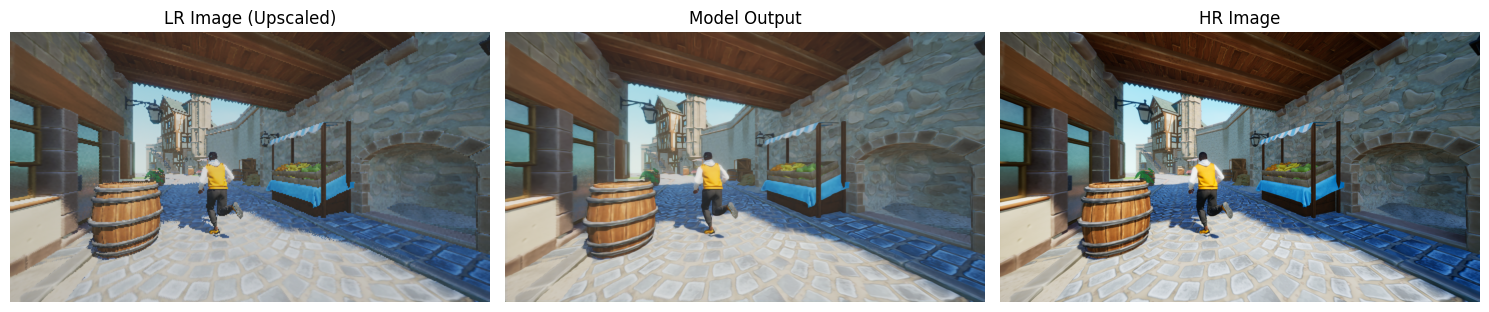

In [18]:
# Lightning 모델 및 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lightning_model = loaded_model.to(device)

# 시각화 실행
visualize_results(lightning_model, lr_dir="LR", hr_dir="HR", device=device)


# Save output image

In [78]:
def process_and_save_images(lightning_model, lr_dir, output_dir, device):
    """
    PyTorch Lightning 모델을 사용하여 LR 이미지를 처리하고 결과를 저장합니다.

    Args:
        lightning_model (LightningModule): PyTorch Lightning 모델.
        lr_dir (str): LR 이미지가 저장된 디렉토리 경로.
        output_dir (str): 결과 이미지를 저장할 디렉토리 경로.
        device (torch.device): GPU 또는 CPU 디바이스.
    """
    # Lightning 모델에서 PyTorch 모델 추출
    model = lightning_model.model
    model.eval()  # 평가 모드 설정
    model.to(device)  # 디바이스로 이동

    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)

    # 이미지 전처리를 위한 변환
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    # LR 디렉토리의 모든 이미지 파일 처리
    for filename in tqdm(os.listdir(lr_dir)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')) and (filename.startswith('ue3') or filename.startswith('ue6')
                                                                    or filename.startswith('ue9') or filename.startswith('ue14')):
        #if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # 이미지 로드 및 전처리
            img_path = os.path.join(lr_dir, filename)
            lr_img = Image.open(img_path).convert('RGB')
            lr_tensor = transform(lr_img).unsqueeze(0).to(device)

            # 모델로 예측
            with torch.no_grad():
                output = model(lr_tensor)

            # 출력 텐서를 이미지로 변환
            output = output.squeeze().cpu().clamp(0, 1).permute(1, 2, 0).numpy()
            output = (output * 255).astype('uint8')
            output_img = Image.fromarray(output)

            # 결과 이미지 저장
            output_path = os.path.join(output_dir, filename)
            output_img.save(output_path)

    print(f"모든 이미지 처리 완료. 결과는 {output_dir} 폴더에 저장되었습니다.")


# 예제 실행
output_dir = 'output_model_cnn6'  # 결과를 저장할 폴더
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 이미지 처리 및 저장 함수 호출
process_and_save_images(
    lightning_model=loaded_model,  # PyTorch Lightning 모델
    lr_dir="LR",   # LR 이미지 경로
    output_dir=output_dir,        # 결과 저장 경로
    device=device                 # 디바이스
)


100%|██████████| 6750/6750 [11:37<00:00,  9.67it/s]

모든 이미지 처리 완료. 결과는 output_model_cnn6 폴더에 저장되었습니다.


# Other Model test

In [10]:
import sys
import os

sys.path.append('NTIRE23_RTSR/demo')
sys.path.append('RT4KSR/code')

In [11]:
from models.rfdn import RFDN
from model.arch import rt4ksr_rep
from model.modules import ResBlock, RepResBlock

In [12]:
modelRFDN = RFDN()  # x4 업스케일링

# 사전 학습된 가중치 로드
checkpoint_path = "NTIRE23_RTSR/demo/model_zoo/rfdn_X4.pth"
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# 가중치를 직접 로드
modelRFDN.load_state_dict(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelRFDN.eval()
modelRFDN.to(device)

RFDN(
  (fea_conv): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (B1): RFDB(
    (c1_d): Conv2d(50, 25, kernel_size=(1, 1), stride=(1, 1))
    (c1_r): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2_d): Conv2d(50, 25, kernel_size=(1, 1), stride=(1, 1))
    (c2_r): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c3_d): Conv2d(50, 25, kernel_size=(1, 1), stride=(1, 1))
    (c3_r): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c4): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (act): LeakyReLU(negative_slope=0.05, inplace=True)
    (c5): Conv2d(100, 50, kernel_size=(1, 1), stride=(1, 1))
    (esa): ESA(
      (conv1): Conv2d(50, 12, kernel_size=(1, 1), stride=(1, 1))
      (conv_f): Conv2d(12, 12, kernel_size=(1, 1), stride=(1, 1))
      (conv_max): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(12, 12, kernel_size=(3, 3), stride=

In [13]:
from model.modules import ResBlock, RepResBlock
import torch.nn.functional as F

# Args 클래스 정의
class Args:
    checkpoint_id = "rt4ksr_x3"
    scale = 3
    arch = "rt4ksr_rep"
    benchmark = "ntire23rtsr"
    is_train = True
    act_type = "relu"
    feature_channels = 24
    num_blocks = 4

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 생성
modelrt4ksr = rt4ksr_rep(args)

# 체크포인트 로드
checkpoint_path = "RT4KSR/code/checkpoints/rt4ksr_x3.pth"
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# 'module.' 제거 후 가중치 로드
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
modelrt4ksr.load_state_dict(state_dict, strict=True)

# 모델을 평가 모드로 전환
modelrt4ksr.eval()
modelrt4ksr.to(device)

RT4KSR_Rep(
  (gaussian): GaussianBlur(kernel_size=(5, 5), sigma=(1, 1))
  (down): PixelUnshuffle(downscale_factor=2)
  (up): PixelShuffle(upscale_factor=2)
  (head): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (hfb): Sequential(
    (0): ResBlock(
      (expand_conv): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
      (fea_conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
      (reduce_conv): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ReLU(inplace=True)
  )
  (body): Sequential(
    (0): SimplifiedNAFBlock(
      (conv1): ResBlock(
        (expand_conv): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
        (fea_conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
        (reduce_conv): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1))
      )
      (act): ReLU(inplace=True)
      (norm): LayerNorm2d()
    )
    (1): SimplifiedNAFBlock(
      (conv1): ResBlock(
        (expand_conv): Conv2d(24, 

In [18]:
class SRDatasetWithScaling(Dataset):
    def __init__(self, lr_dir, hr_dir, scale=4, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.scale = scale
        self.transform = transform

        self.image_files = [
            f for f in os.listdir(lr_dir)
            if os.path.isfile(os.path.join(lr_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        try:
            lr_path = os.path.join(self.lr_dir, self.image_files[idx])
            hr_path = os.path.join(self.hr_dir, self.image_files[idx])

            lr_image = Image.open(lr_path).convert('RGB')
            hr_image = Image.open(hr_path).convert('RGB')

            # HR 이미지를 항상 scale에 따라 조정
            target_size = (lr_image.width * self.scale, lr_image.height * self.scale)
            hr_image = hr_image.resize(target_size, Image.BICUBIC)

            if self.transform:
                lr_image = self.transform(lr_image)
                hr_image = self.transform(hr_image)

            return lr_image, hr_image
        except Exception as e:
            print(f"Error loading image at index {idx}: {e}")
            raise e


def evaluate_fuse_model(model, test_loader, device):
    model.eval()
    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    lpips_metric = lpips.LPIPS(net='alex').to(device)
    sys.stdout.close()
    sys.stdout = original_stdout
        
    psnr_scores = []
    ssim_scores = []
    lpips_scores = []
    runtimes = []

    with torch.no_grad():
        for lr_imgs, hr_imgs in tqdm(test_loader, desc="Evaluating"):
            lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)

            start_time = time.time()
            outputs = model(lr_imgs)
            end_time = time.time()

            runtimes.append(end_time - start_time)

            for i in range(outputs.size(0)):
                sr_img = outputs[i].permute(1, 2, 0).cpu().numpy()
                hr_img = hr_imgs[i].permute(1, 2, 0).cpu().numpy()

                # 크기 확인
                if sr_img.shape != hr_img.shape:
                    print(f"Mismatch in dimensions: SR {sr_img.shape}, HR {hr_img.shape}")
                    raise ValueError("Input images must have the same dimensions.")

                sr_img = np.clip(sr_img, 0, 1)
                hr_img = np.clip(hr_img, 0, 1)

                psnr_scores.append(peak_signal_noise_ratio(hr_img, sr_img, data_range=1))

                min_size = min(sr_img.shape[0], sr_img.shape[1])
                win_size = min(7, min_size)
                if win_size % 2 == 0:
                    win_size -= 1

                ssim_scores.append(structural_similarity(
                    hr_img, sr_img, channel_axis=2, win_size=win_size, data_range=1
                ))

            lpips_scores.append(lpips_metric(outputs, hr_imgs).mean().item())

    avg_psnr = np.mean(psnr_scores)
    avg_ssim = np.mean(ssim_scores)
    avg_lpips = np.mean(lpips_scores)
    avg_runtime = np.mean(runtimes)

    return avg_psnr, avg_ssim, avg_lpips, avg_runtime

In [15]:
# 데이터셋 및 평가 로더 설정
scale = 4  # n배 업스케일링
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset3 = SRDatasetWithScaling(lr_dir="LR", hr_dir="HR", scale=3, transform=transform)

In [16]:
# 데이터셋 및 평가 로더 설정
scale = 4  # n배 업스케일링
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset4 = SRDatasetWithScaling(lr_dir="LR", hr_dir="HR", scale=4, transform=transform)

In [29]:
def visualize_sr_results(model, dataset, output_dir="visualize_result", filename="plt2result.png", device="cuda"):
    """
    초해상도 모델 결과를 시각화하고 저장하는 함수.
    
    Args:
        model: 초해상도 모델 (PyTorch 모델 객체)
        dataset: 데이터셋 (저해상도 및 고해상도 이미지 쌍을 제공하는 데이터셋 객체)
        output_dir: 결과 저장 폴더 경로 (기본값: "visualize_result")
        filename: 저장 파일 이름 (기본값: "result.png")
        device: 사용할 디바이스 (기본값: "cuda")
    
    Returns:
        None
    """
    # 랜덤 인덱스 선택 및 데이터 로드
    random_idx = random.randint(0, len(dataset) - 1)
    lr_image, hr_image = dataset[random_idx]

    # 배치 차원을 추가하고 디바이스에 올리기
    lr_image = lr_image.unsqueeze(0).to(device)
    hr_image = hr_image.unsqueeze(0).to(device)

    # 모델 출력 계산
    model.eval()
    with torch.no_grad():
        sr_image = model(lr_image)

    # 출력 크기와 원본 크기 출력
    print(f"Input LR Shape: {lr_image.shape}")
    print(f"Output SR Shape: {sr_image.shape}")
    print(f"Target HR Shape: {hr_image.shape}")

    # 결과 저장 경로 설정
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, filename)

    # 시각화 및 저장
    plt.figure(figsize=(15, 5))

    # 저해상도 이미지 (LR)
    plt.subplot(1, 3, 1)
    plt.title("Low-Resolution (LR)")
    plt.imshow(lr_image.squeeze(0).permute(1, 2, 0).cpu().numpy())
    plt.axis("off")

    # 모델 출력 초해상도 이미지 (SR)
    plt.subplot(1, 3, 2)
    plt.title("Super-Resolution (SR)")
    plt.imshow(sr_image.squeeze(0).permute(1, 2, 0).cpu().numpy())
    plt.axis("off")

    # 고해상도 이미지 (HR)
    plt.subplot(1, 3, 3)
    plt.title("High-Resolution (HR)")
    plt.imshow(hr_image.squeeze(0).permute(1, 2, 0).cpu().numpy())
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3340611..1.8154835].


Input LR Shape: torch.Size([1, 3, 270, 480])
Output SR Shape: torch.Size([1, 3, 1080, 1920])
Target HR Shape: torch.Size([1, 3, 1080, 1920])


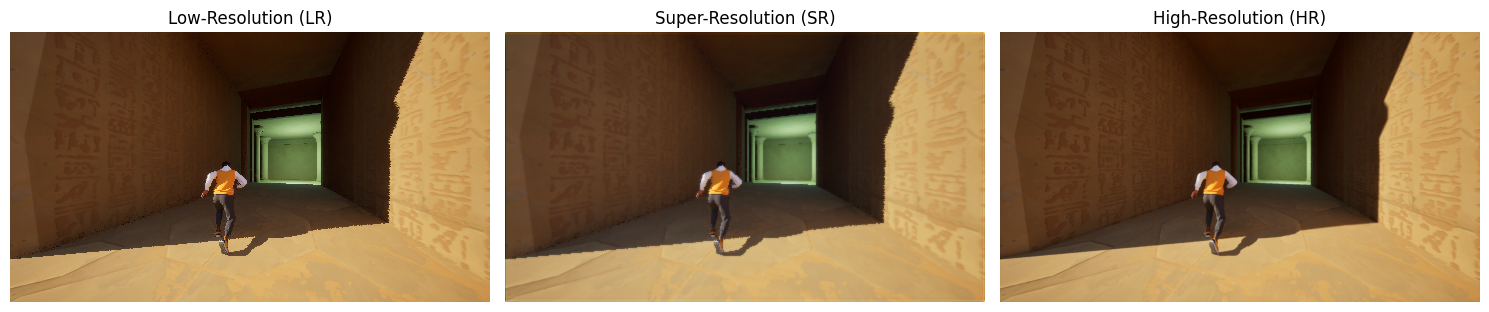

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32701823..1.4006529].


Input LR Shape: torch.Size([1, 3, 270, 480])
Output SR Shape: torch.Size([1, 3, 810, 1440])
Target HR Shape: torch.Size([1, 3, 810, 1440])


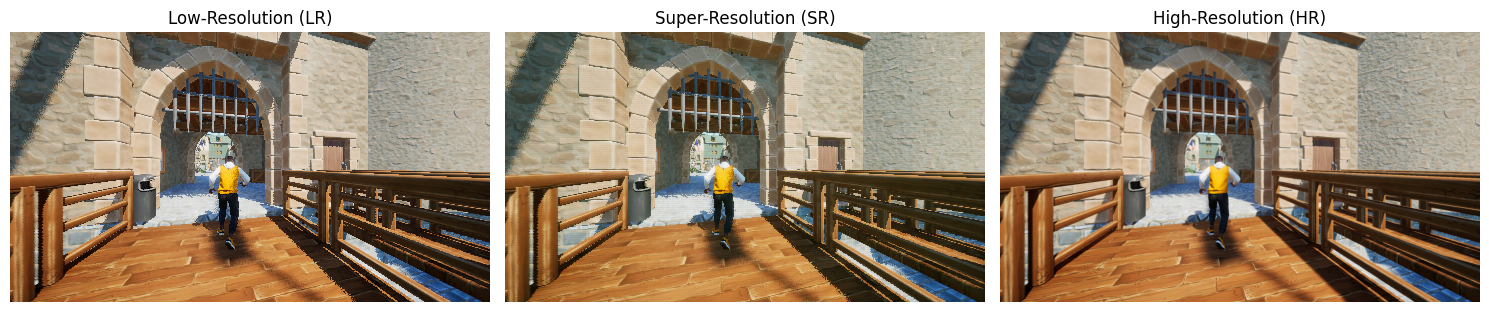

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011367962..1.0595313].


Input LR Shape: torch.Size([1, 3, 270, 480])
Output SR Shape: torch.Size([1, 3, 1080, 1920])
Target HR Shape: torch.Size([1, 3, 1080, 1920])


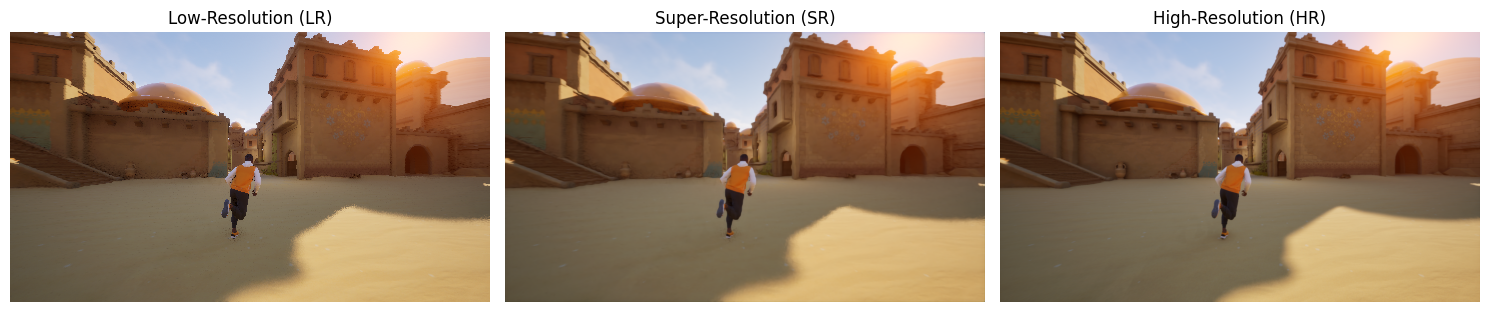

In [31]:
visualize_sr_results(modelRFDN, dataset4, filename="modelRFDN_result.png")
visualize_sr_results(modelrt4ksr, dataset3, filename="modelrt4ksr_result.png")
visualize_sr_results(loaded_model, dataset4, filename="loaded_model_result.png")

# PSNR, RunTime Test

## RFDN x4 Result

In [8]:
from torch.utils.data import DataLoader, Subset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelRFDN.to(device)

subset_size = 10  # 제한할 데이터 개수
subset_indices = list(range(subset_size))  # 첫 subset_size만큼의 인덱스 선택

# Subset에서 데이터셋 직접 가져오기
limited_dataset = Subset(dataset4, subset_indices)  # SRDatasetWithScaling 사용
limited_test_loader = DataLoader(limited_dataset, batch_size=1, shuffle=False)

# 평가 실행
avg_psnr, avg_ssim, avg_lpips, avg_runtime = evaluate_fuse_model(modelRFDN, limited_test_loader, device)
flops, params = get_model_complexity(modelRFDN)

print("RFDN X4 model result")
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"Average LPIPS: {avg_lpips:.4f}")
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")
print(f"Parameters: {params / 1e6:.2f} Million")
print(f"Average Runtime: {avg_runtime * 1000:.2f} ms")

Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


RFDN X4 model result
Average PSNR: 24.94 dB
Average SSIM: 0.5771
Average LPIPS: 0.3612
FLOPs: 53.83 GFLOPs
Parameters: 0.43 Million
Average Runtime: 4.45 ms


## RT4KSR x3 Result

In [9]:
from torch.utils.data import DataLoader, Subset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelrt4ksr.to(device)

subset_size = 10  # 제한할 데이터 개수
subset_indices = list(range(subset_size))  # 첫 subset_size만큼의 인덱스 선택

# Subset에서 데이터셋 직접 가져오기
limited_dataset = Subset(dataset3, subset_indices)  # SRDatasetWithScaling 사용
limited_test_loader = DataLoader(limited_dataset, batch_size=1, shuffle=False)

# 평가 실행
avg_psnr, avg_ssim, avg_lpips, avg_runtime = evaluate_fuse_model(modelrt4ksr, limited_test_loader, device)
flops, params = get_model_complexity(modelrt4ksr)

print("RT4KSR X3 model result")
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"Average LPIPS: {avg_lpips:.4f}")
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")
print(f"Parameters: {params / 1e6:.2f} Million")
print(f"Average Runtime: {avg_runtime * 1000:.2f} ms")

Evaluating: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


RT4KSR X3 model result
Average PSNR: 24.24 dB
Average SSIM: 0.4568
Average LPIPS: 0.5108
FLOPs: 5.45 GFLOPs
Parameters: 0.17 Million
Average Runtime: 3.75 ms


## Our Model Result

In [10]:
from torch.utils.data import DataLoader, Subset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

subset_size = 10  # 제한할 데이터 개수
subset_indices = list(range(subset_size))  # 첫 subset_size만큼의 인덱스 선택

# Subset에서 데이터셋 직접 가져오기
limited_dataset = Subset(dataset4, subset_indices)  # SRDatasetWithScaling 사용
limited_test_loader = DataLoader(limited_dataset, batch_size=1, shuffle=False)

# 평가 실행
avg_psnr, avg_ssim, avg_lpips, avg_runtime = evaluate_fuse_model(loaded_model, limited_test_loader, device)
flops, params = get_model_complexity(loaded_model)

print("out model result")
print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average SSIM: {avg_ssim:.4f}")
print(f"Average LPIPS: {avg_lpips:.4f}")
print(f"FLOPs: {flops / 1e9:.2f} GFLOPs")
print(f"Parameters: {params / 1e6:.2f} Million")
print(f"Average Runtime: {avg_runtime * 1000:.2f} ms")

Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


out model result
Average PSNR: 28.16 dB
Average SSIM: 0.8233
Average LPIPS: 0.2039
FLOPs: 101.81 GFLOPs
Parameters: 0.79 Million
Average Runtime: 2.97 ms
